In [39]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.express as px

ANALYSIS_PATH = Path(os.getcwd())
ROOT_PATH = ANALYSIS_PATH.parent
SRC_PATH = ROOT_PATH.joinpath('src')
DATA_PATH = ROOT_PATH.joinpath('data')

In [16]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

In [17]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)


In [19]:
1.230772e+09

1230772000.0

In [22]:
all_data = pd.read_csv(DATA_PATH.joinpath("all_data_daily.csv"))
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data

,Date,Country,TotalLoadValue
0,2014-12-01,Austria,25801.2
1,2014-12-02,Austria,728087.6
2,2014-12-03,Austria,730588.8
3,2014-12-04,Austria,751961.6
4,2014-12-05,Austria,721206.8
...,...,...,...
56236,2021-05-28,United Kingdom,1551461.0
56237,2021-05-29,United Kingdom,1397079.0
56238,2021-05-30,United Kingdom,1293924.0
56239,2021-05-31,United Kingdom,1410300.0


In [12]:
day = 1
year = 365.2425

## Feature Engineering

In [48]:
all_data["DayOfYear"] = all_data['Date'].apply(lambda x: int(x.dayofyear))
all_data["YearSin"] = np.sin(all_data['DayOfYear'] * (2 * np.pi / year))
all_data["YearCos"] = np.cos(all_data['DayOfYear'] * (2 * np.pi / year))
all_data["Year"] = all_data['Date'].apply(lambda x: int(x.year))

In [50]:
aus = all_data[all_data['Country']=="Austria"]
aus

,Date,Country,TotalLoadValue,DayOfYear,YearSin,YearCos,Year
0,2014-12-01,Austria,25801.2,335,-0.497101,0.867692,2014
1,2014-12-02,Austria,728087.6,336,-0.482102,0.876115,2014
2,2014-12-03,Austria,730588.8,337,-0.466960,0.884279,2014
3,2014-12-04,Austria,751961.6,338,-0.451679,0.892180,2014
4,2014-12-05,Austria,721206.8,339,-0.436265,0.899818,2014
...,...,...,...,...,...,...,...
2371,2021-05-29,Austria,567318.0,149,0.546667,-0.837350,2021
2372,2021-05-30,Austria,518176.4,150,0.532182,-0.846630,2021
2373,2021-05-31,Austria,655933.6,151,0.517540,-0.855659,2021
2374,2021-06-01,Austria,665577.6,152,0.502744,-0.864435,2021


## Data Split

In [51]:
df = aus.drop(["Date", "Country"], axis=1)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Data Normalisation

In [54]:
train_mean = train_df.mean()
train_std = train_df.std()

In [56]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

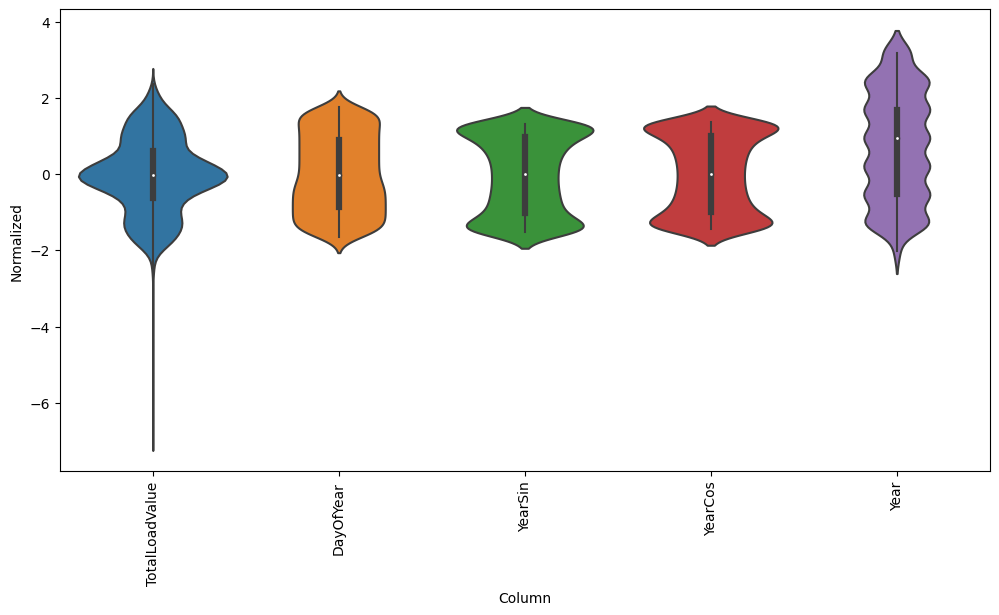

In [57]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [105]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='TotalLoadValue', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [d]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


In [106]:
w1 = WindowGenerator(input_width=20, label_width=1, shift=1,
                     label_columns=['TotalLoadValue'])
w1

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20]
Label column name(s): ['TotalLoadValue']

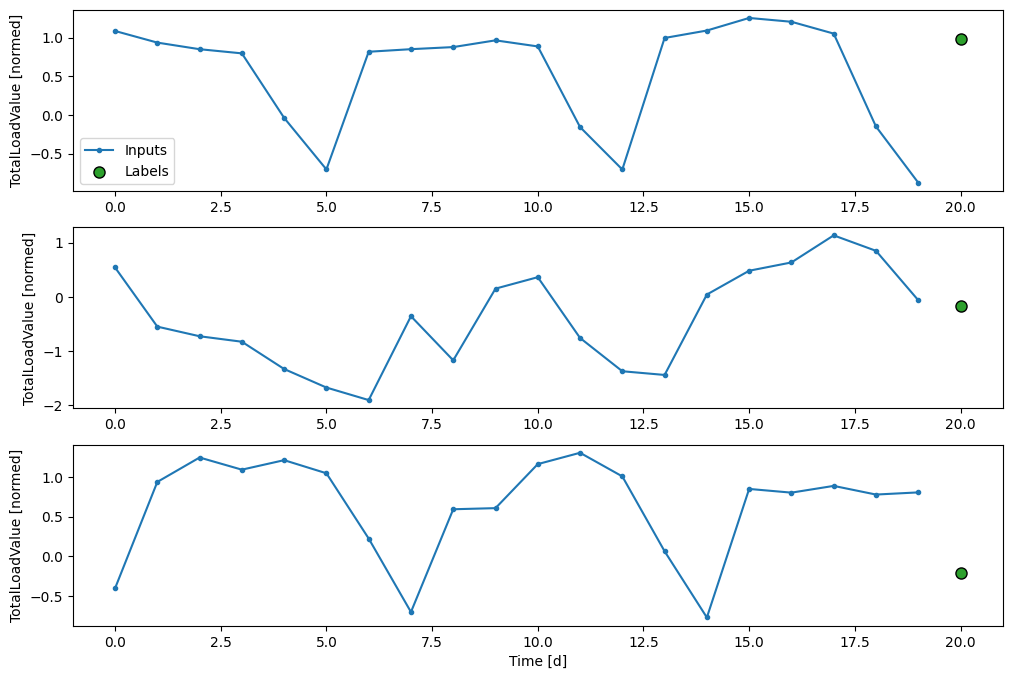

In [110]:
w1.plot()

## Single Step Model

In [115]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['TotalLoadValue'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['TotalLoadValue']

In [116]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [117]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [118]:
baseline = Baseline(label_index=column_indices['TotalLoadValue'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

15/15 [==============================] - 1s 2ms/step - loss: 0.5113 - mean_absolute_error: 0.4979


In [121]:
wide_window = WindowGenerator(
    input_width=20, label_width=20, shift=1,
    label_columns=['TotalLoadValue'])

wide_window

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label column name(s): ['TotalLoadValue']

In [122]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 20, 5)
Output shape: (32, 20, 1)


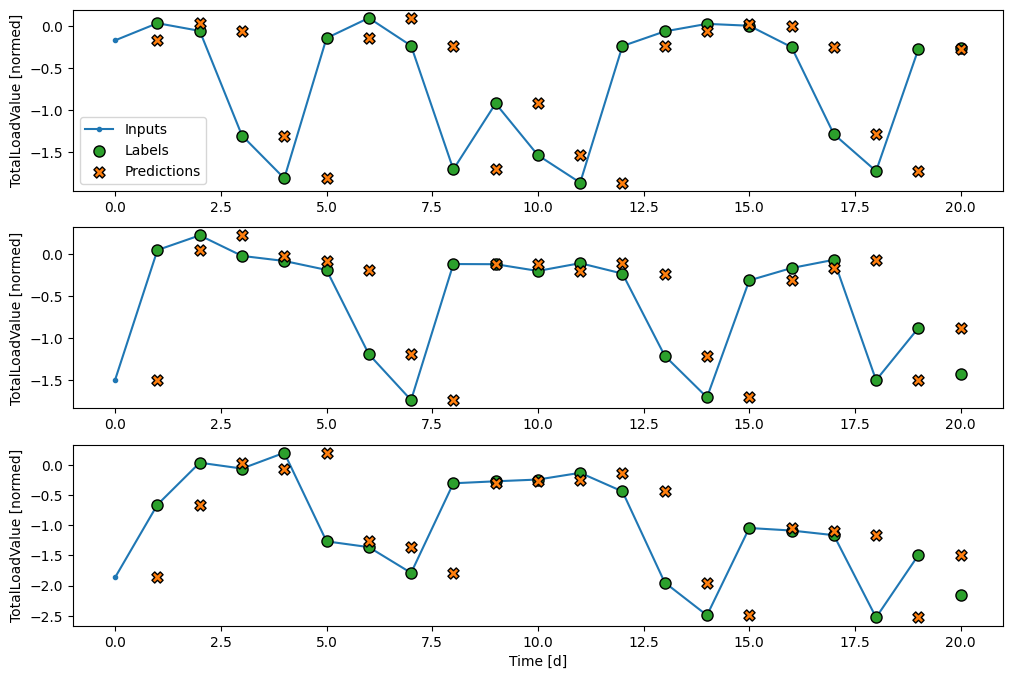

In [123]:
wide_window.plot(baseline)


#### Linear Model

In [125]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [126]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [127]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
52/52 [==============================] - 1s 4ms/step - loss: 2.2847 - mean_absolute_error: 1.1874 - val_loss: 2.2530 - val_mean_absolute_error: 1.2547
Epoch 2/20
52/52 [==============================] - 0s 3ms/step - loss: 2.0803 - mean_absolute_error: 1.1330 - val_loss: 1.9654 - val_mean_absolute_error: 1.1727
Epoch 3/20
52/52 [==============================] - 0s 2ms/step - loss: 1.8996 - mean_absolute_error: 1.0828 - val_loss: 1.7180 - val_mean_absolute_error: 1.0956
Epoch 4/20
52/52 [==============================] - 0s 2ms/step - loss: 1.7409 - mean_absolute_error: 1.0365 - val_loss: 1.5106 - val_mean_absolute_error: 1.0286
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 1.6015 - mean_absolute_error: 0.9951 - val_loss: 1.3394 - val_mean_absolute_error: 0.9680
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 1.4784 - mean_absolute_error: 0.9574 - val_loss: 1.1992 - val_mean_absolute_error: 0.9148
Epoch 7/20
52/52 [==========

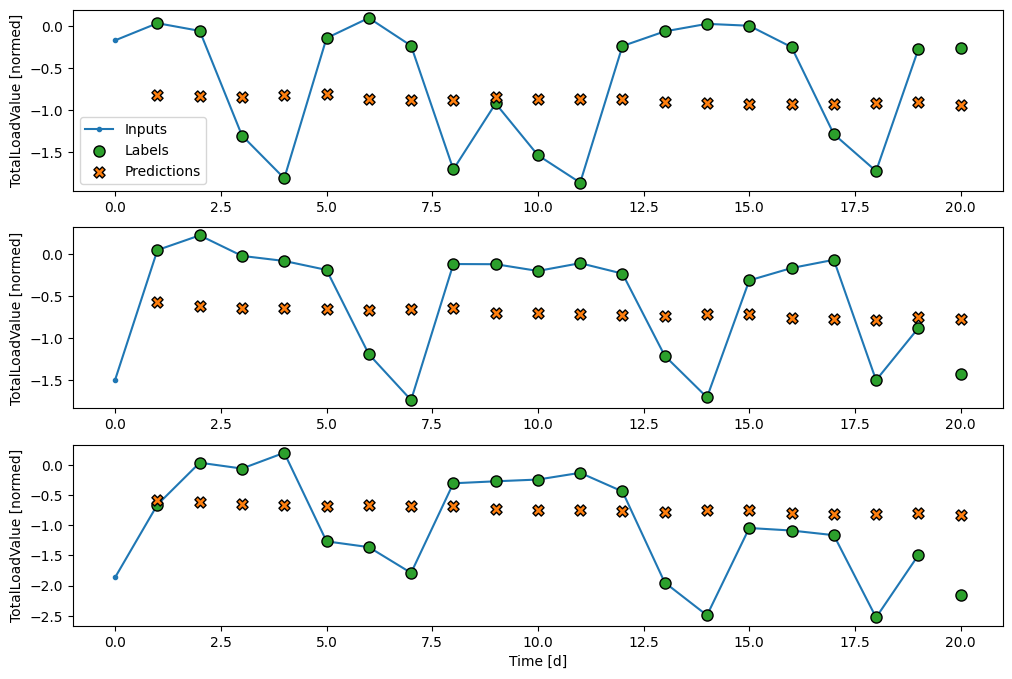

In [128]:
wide_window.plot(linear)

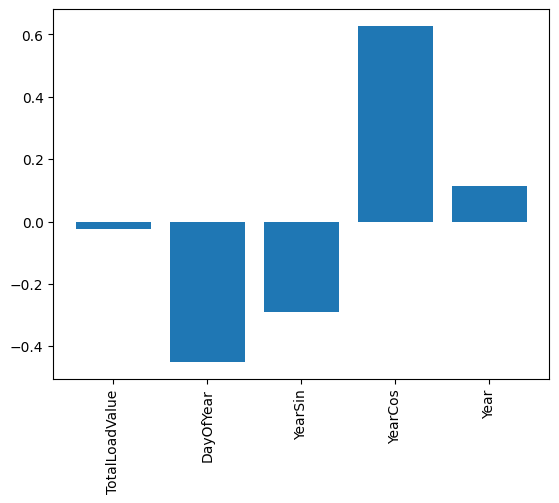

In [129]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense Model

In [130]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
43/52 [=======================>......] - ETA: 0s - loss: 0.6447 - mean_absolute_error: 0.6355

2022-10-10 19:52:06.796557: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


52/52 [==============================] - 1s 5ms/step - loss: 0.6144 - mean_absolute_error: 0.6242 - val_loss: 0.4311 - val_mean_absolute_error: 0.5234
Epoch 2/20
52/52 [==============================] - 0s 3ms/step - loss: 0.4501 - mean_absolute_error: 0.5484 - val_loss: 0.4148 - val_mean_absolute_error: 0.5044
Epoch 3/20
52/52 [==============================] - 0s 2ms/step - loss: 0.4366 - mean_absolute_error: 0.5375 - val_loss: 0.3915 - val_mean_absolute_error: 0.4893
Epoch 4/20
52/52 [==============================] - 0s 3ms/step - loss: 0.4265 - mean_absolute_error: 0.5279 - val_loss: 0.3721 - val_mean_absolute_error: 0.5093
Epoch 5/20
52/52 [==============================] - 0s 3ms/step - loss: 0.4119 - mean_absolute_error: 0.5191 - val_loss: 0.3657 - val_mean_absolute_error: 0.5139
Epoch 6/20
52/52 [==============================] - 0s 3ms/step - loss: 0.4032 - mean_absolute_error: 0.5127 - val_loss: 0.3929 - val_mean_absolute_error: 0.5449
Epoch 7/20
15/15 [=====================

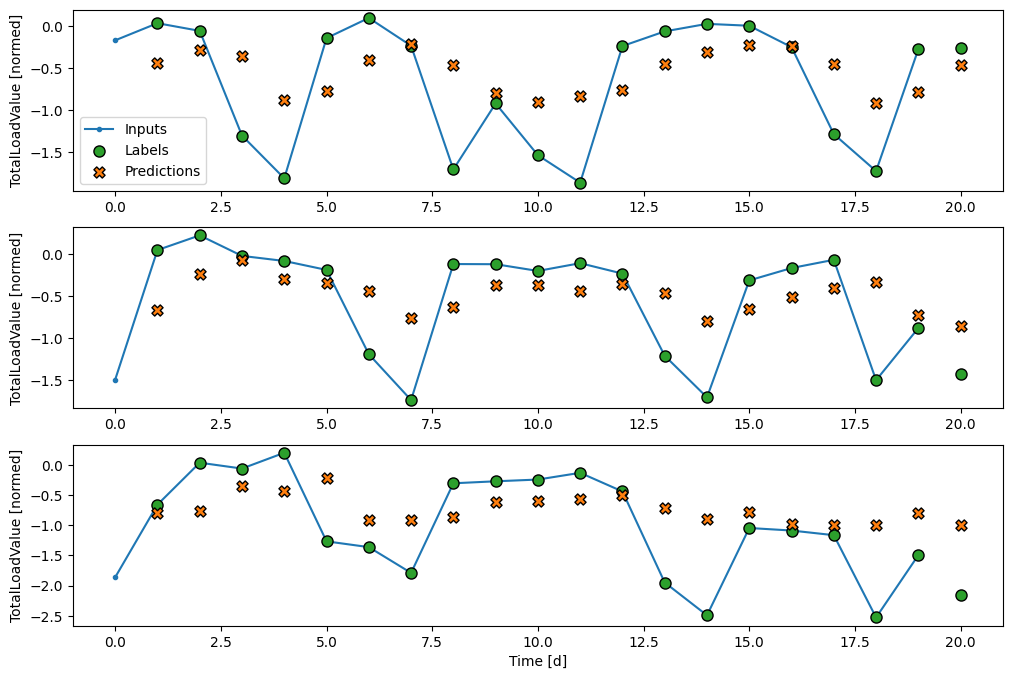

In [131]:
wide_window.plot(dense)

### Multi-Step dense

In [174]:
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['TotalLoadValue'])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['TotalLoadValue']

Text(0.5, 1.0, 'Given 10 days of inputs, predict 1 day into the future.')

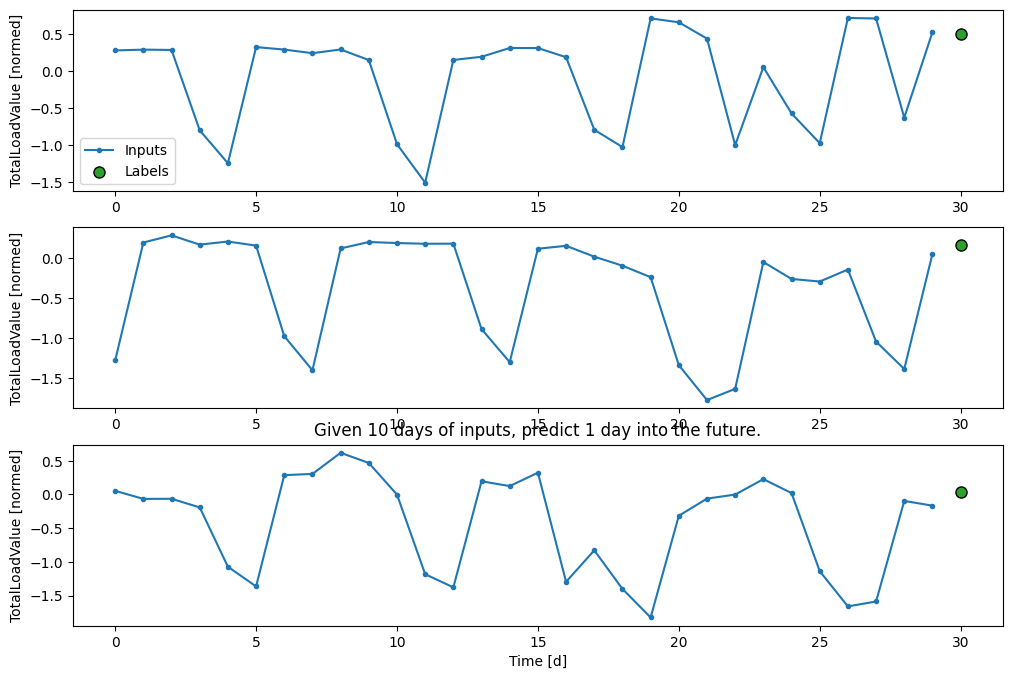

In [175]:
conv_window.plot()
plt.title("Given 10 days of inputs, predict 1 day into the future.")

In [176]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 5)
Output shape: (32, 1, 1)


In [177]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
52/52 [==============================] - 1s 6ms/step - loss: 0.5652 - mean_absolute_error: 0.5564 - val_loss: 0.4779 - val_mean_absolute_error: 0.5410
Epoch 2/20
52/52 [==============================] - 0s 2ms/step - loss: 0.2556 - mean_absolute_error: 0.3593 - val_loss: 0.3073 - val_mean_absolute_error: 0.4246
Epoch 3/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2059 - mean_absolute_error: 0.3101 - val_loss: 0.2629 - val_mean_absolute_error: 0.3943
Epoch 4/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1847 - mean_absolute_error: 0.2867 - val_loss: 0.2864 - val_mean_absolute_error: 0.4292
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1816 - mean_absolute_error: 0.2806 - val_loss: 0.2387 - val_mean_absolute_error: 0.3771
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1675 - mean_absolute_error: 0.2699 - val_loss: 0.1951 - val_mean_absolute_error: 0.3374
Epoch 7/20
52/52 [==========

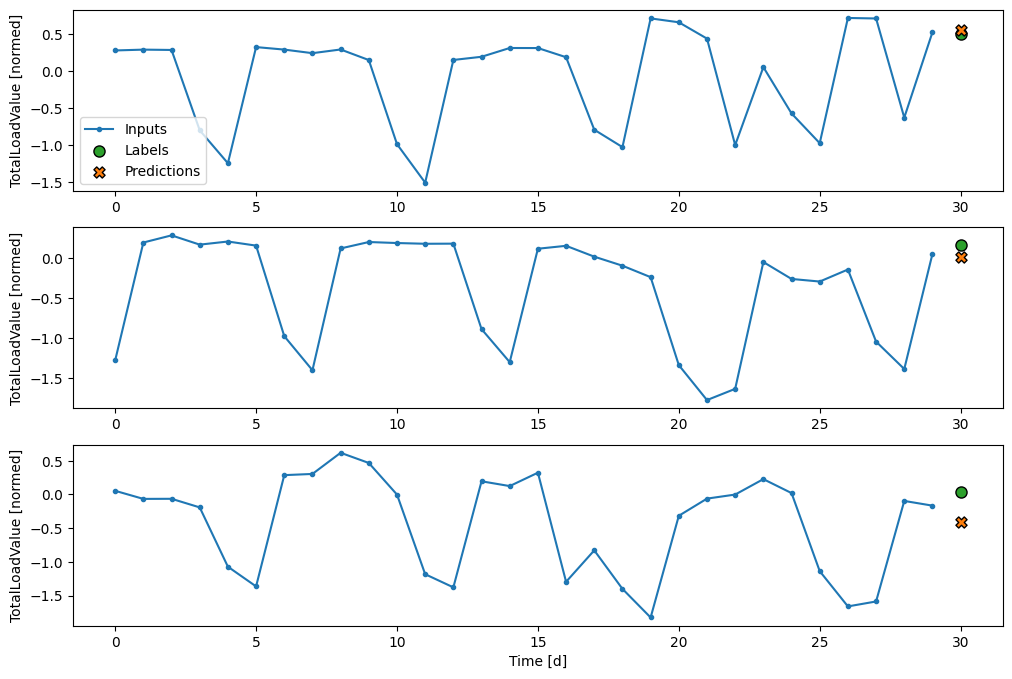

In [178]:
conv_window.plot(multi_step_dense)

### CNN

In [179]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 5)
Output shape: (32, 1, 1)


In [180]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
52/52 [==============================] - 1s 5ms/step - loss: 0.4621 - mean_absolute_error: 0.5119 - val_loss: 0.2806 - val_mean_absolute_error: 0.4004
Epoch 2/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2505 - mean_absolute_error: 0.3419 - val_loss: 0.2534 - val_mean_absolute_error: 0.3605
Epoch 3/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1945 - mean_absolute_error: 0.2923 - val_loss: 0.1946 - val_mean_absolute_error: 0.3170
Epoch 4/20
52/52 [==============================] - 0s 3ms/step - loss: 0.1804 - mean_absolute_error: 0.2738 - val_loss: 0.1558 - val_mean_absolute_error: 0.2777
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1725 - mean_absolute_error: 0.2737 - val_loss: 0.1563 - val_mean_absolute_error: 0.2758
Epoch 6/20
14/14 [==============================] - 0s 1ms/step - loss: 0.1707 - mean_absolute_error: 0.3126


In [181]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['TotalLoadValue'])

wide_conv_window

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): ['TotalLoadValue']

In [182]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 53, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


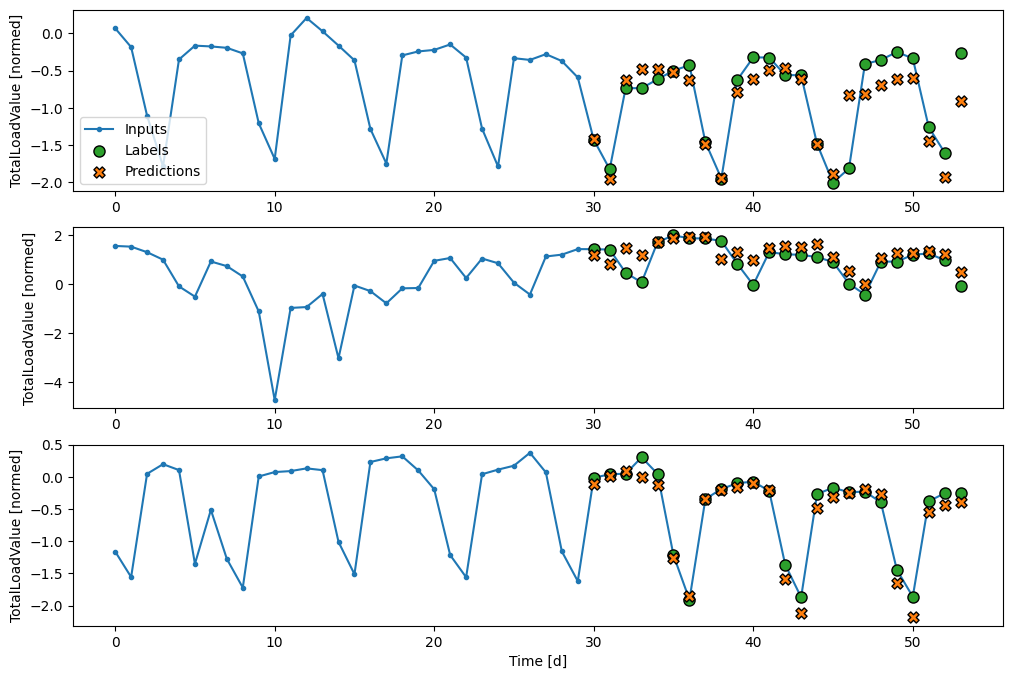

In [185]:
wide_conv_window.plot(conv_model)

In [197]:
ap2 = aus[['TotalLoadValue']]
ap2

,TotalLoadValue
0,25801.2
1,728087.6
2,730588.8
3,751961.6
4,721206.8
...,...
2371,567318.0
2372,518176.4
2373,655933.6
2374,665577.6


In [198]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d = i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [199]:
#Split data set into testing dataset and train dataset
train_size = 1600
train, test = ap2.values[0:train_size,:],ap2.values[train_size:len(ap2.values),:]

# setup look_back window 
look_back = 30
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)